In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('bank-additional.csv', sep=';')
pd.set_option('display.max_columns', None)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


I will remove pdays column because more than 80 percent is lost (999). So better to remove it.

In [3]:
df.drop('pdays', axis=1, inplace=True)
df.drop('poutcome', axis=1, inplace=True)

In [4]:
df.replace("unknown", None, inplace=True)

In [5]:
df = df.dropna(subset=['job', 'marital'])
#'education','default','housing','loan'

In [6]:
df.isnull().sum()

age                 0
job                 0
marital             0
education         154
default           784
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
previous            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

In [7]:
df.shape

(4069, 19)

In [8]:
from scipy.stats import anderson

num_cols = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

for col in num_cols:
    data = df[col]

    # Anderson-Darling test for normality
    result = anderson(data)
    print(f"{col}: Anderson-Darling test - Statistic={result.statistic}, Critical Values={result.critical_values}, Significance Levels={result.significance_level}")


age: Anderson-Darling test - Statistic=46.61995704249239, Critical Values=[0.575 0.655 0.786 0.917 1.091], Significance Levels=[15.  10.   5.   2.5  1. ]
duration: Anderson-Darling test - Statistic=270.105354399494, Critical Values=[0.575 0.655 0.786 0.917 1.091], Significance Levels=[15.  10.   5.   2.5  1. ]
campaign: Anderson-Darling test - Statistic=439.0545911869476, Critical Values=[0.575 0.655 0.786 0.917 1.091], Significance Levels=[15.  10.   5.   2.5  1. ]
previous: Anderson-Darling test - Statistic=1055.4513593841484, Critical Values=[0.575 0.655 0.786 0.917 1.091], Significance Levels=[15.  10.   5.   2.5  1. ]
emp.var.rate: Anderson-Darling test - Statistic=424.02956871881906, Critical Values=[0.575 0.655 0.786 0.917 1.091], Significance Levels=[15.  10.   5.   2.5  1. ]
cons.price.idx: Anderson-Darling test - Statistic=115.2650637503175, Critical Values=[0.575 0.655 0.786 0.917 1.091], Significance Levels=[15.  10.   5.   2.5  1. ]
cons.conf.idx: Anderson-Darling test - S

Non of the numerical values are not normally distributed according to anderson test. So I will use interquartile range test. I used Winsorizing involves setting extreme values to a specified percentile. For example, you can set the top 5% of values to the 95th percentile and the bottom 5% to the 5th percentile.

I tried to remove outliers but my entries reduced by almsost %40 percent. So i will do something else.

In [9]:
def winsorize(data, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = data[column].quantile(lower_percentile)
    upper_bound = data[column].quantile(upper_percentile)
    data[column] = np.where(data[column] < lower_bound, lower_bound, np.where(data[column] > upper_bound, upper_bound, data[column]))

columns_with_outliers = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Apply winsorizing for specified columns
for column in columns_with_outliers:
    winsorize(df, column)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30.0,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487.0,2.0,0.0,-1.8,92.893,-46.2,1.313,5099.1,no
1,39.0,services,single,high.school,no,no,no,telephone,may,fri,346.0,4.0,0.0,1.1,93.994,-36.4,4.855,5191.0,no
2,26.0,services,married,high.school,no,yes,no,telephone,jun,wed,227.0,1.0,0.0,1.4,94.465,-41.8,4.962,5228.1,no
3,38.0,services,married,basic.9y,no,None,None,telephone,jun,fri,35.0,3.0,0.0,1.4,94.465,-41.8,4.959,5228.1,no
4,47.0,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58.0,1.0,0.0,-0.1,93.200,-42.0,4.191,5195.8,no


In [11]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['job', 'marital', 'education', 'default', 'housing','loan','contact','month','day_of_week','y']
num_cols = ['age', 'duration', 'campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

label_encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

df = pd.concat([df[num_cols], df[categorical_cols]], axis=1)

imputer = KNNImputer(n_neighbors = 3)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

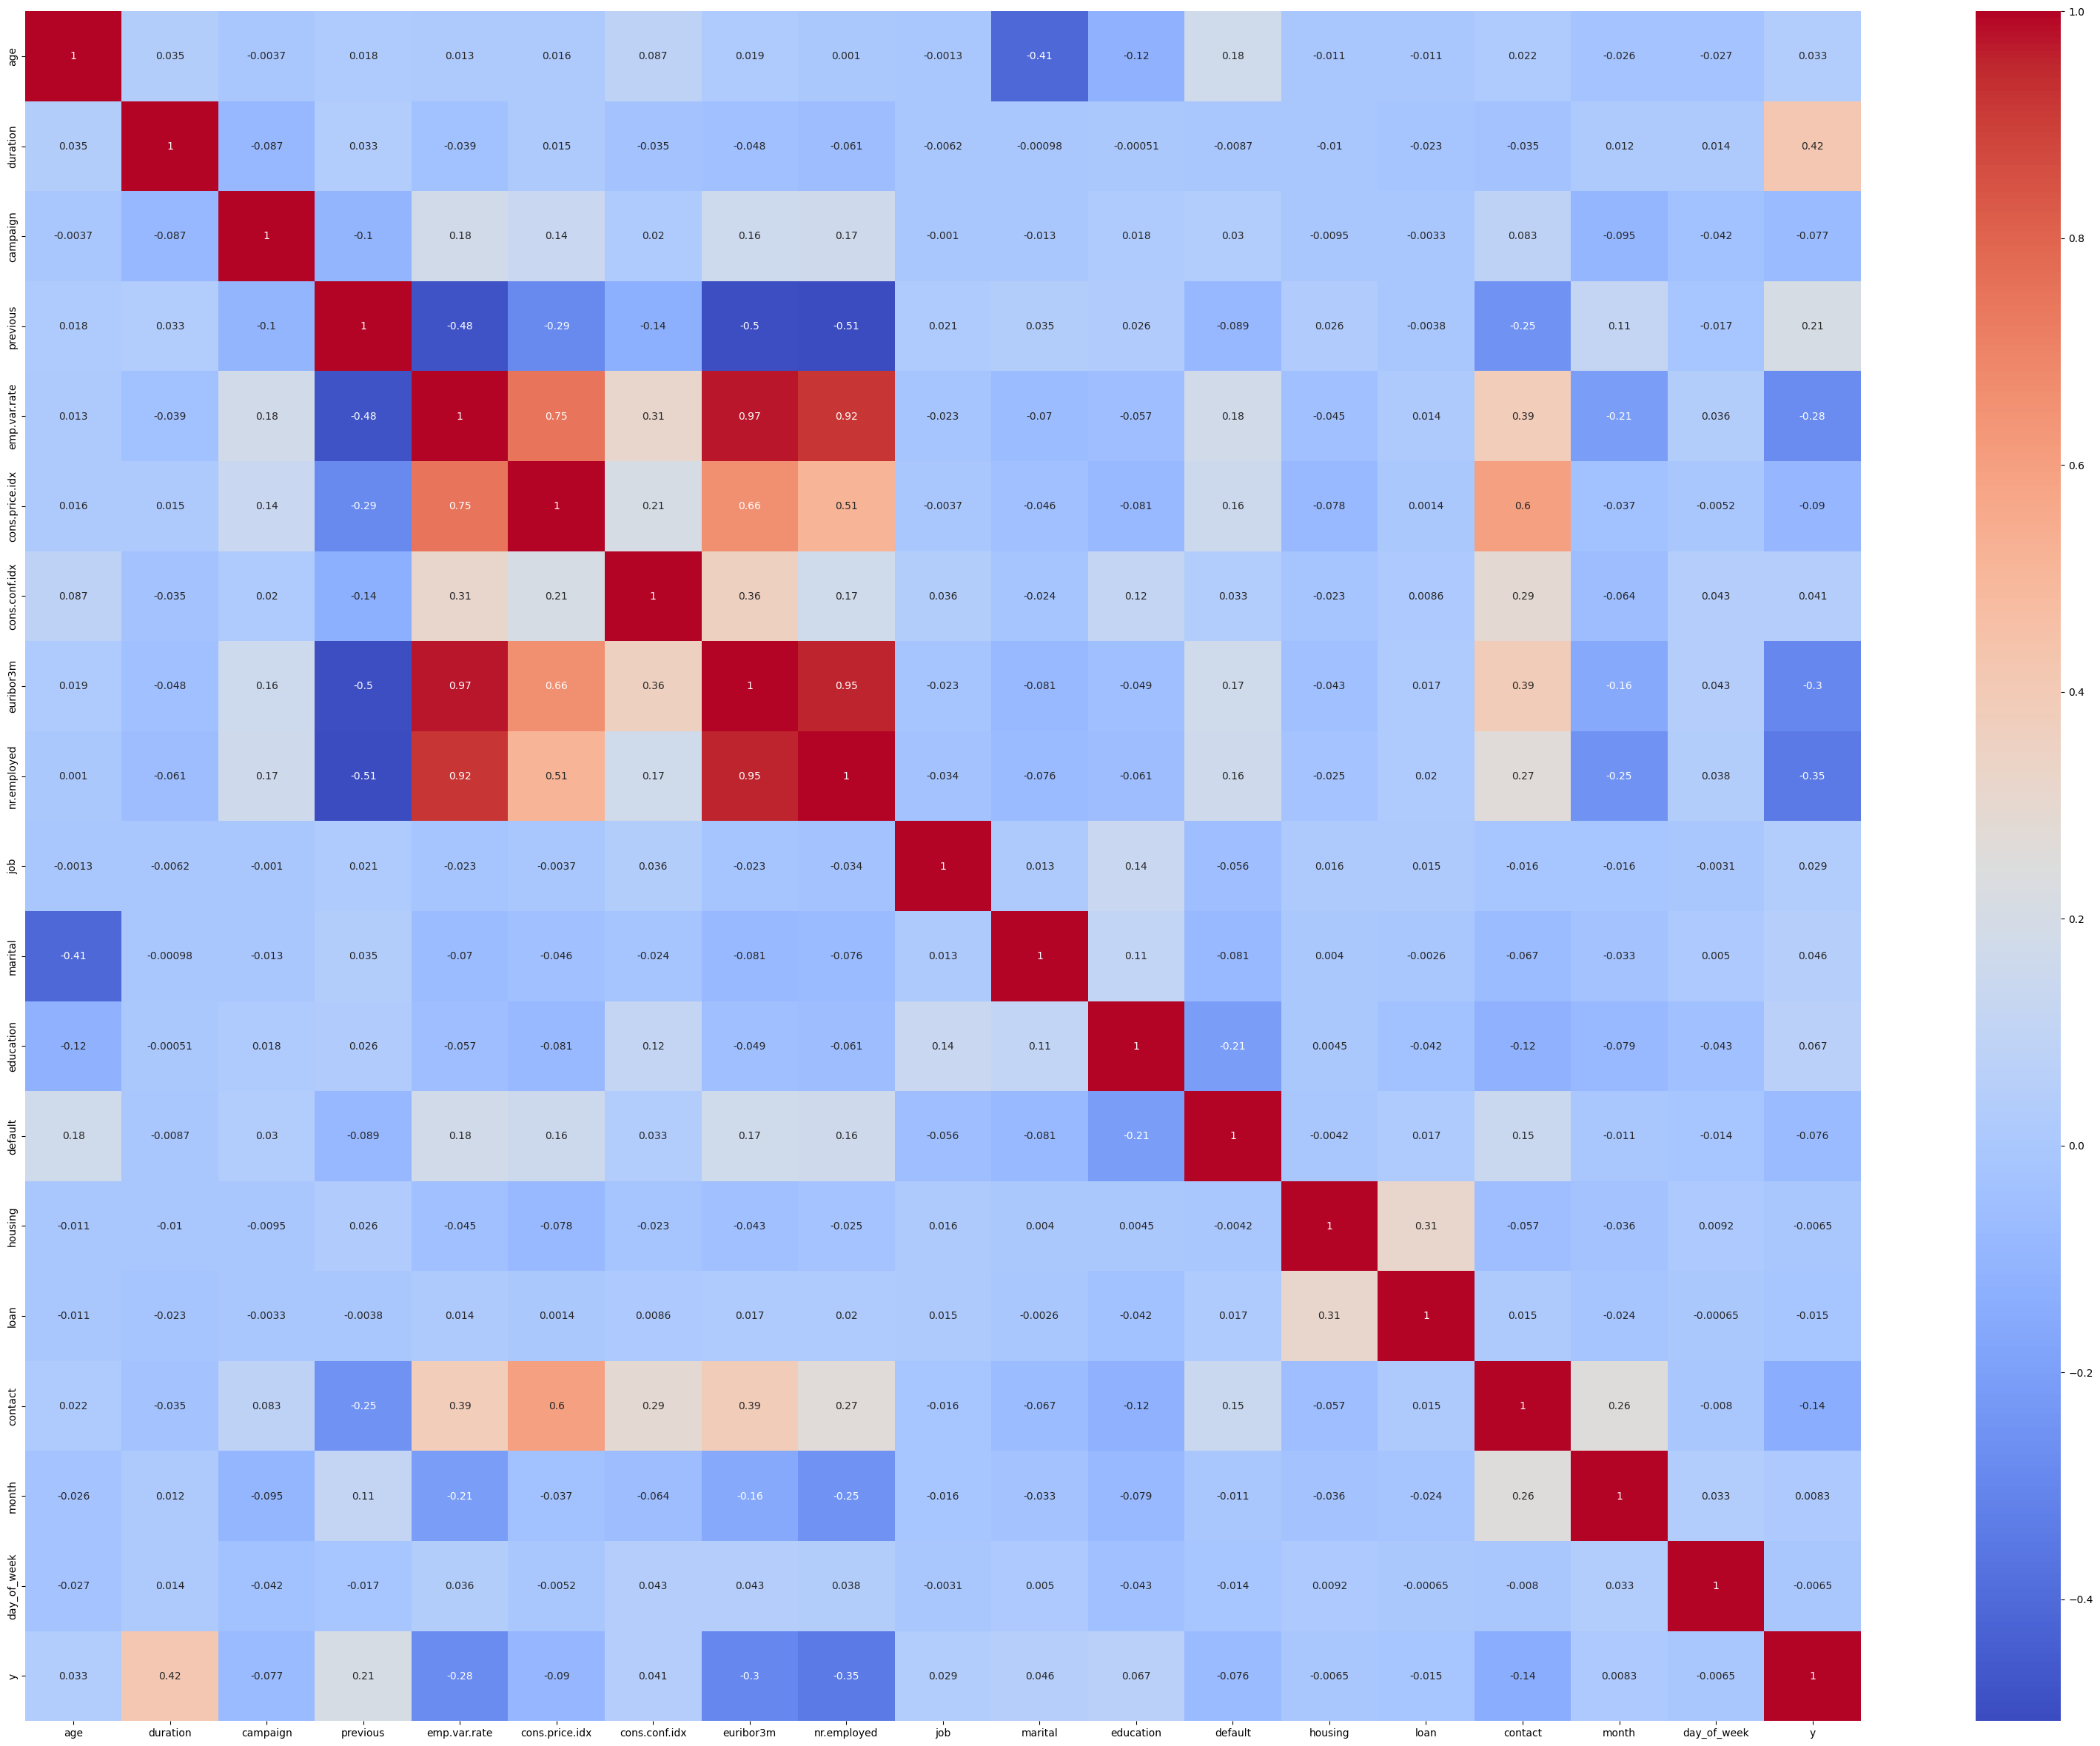

In [14]:

correlation_matrix = df.corr()
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [16]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['y'], axis=1)  # Adjust columns accordingly
y = df['y']

# Fit a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X, y)

# Display feature importances
feature_importances = clf.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.0882857  0.29466668 0.04323272 0.01688247 0.02797609 0.02977942
 0.02930999 0.12623144 0.07562959 0.05521991 0.0267684  0.04626681
 0.01074528 0.02164153 0.0151851  0.01414475 0.03157463 0.04645949]


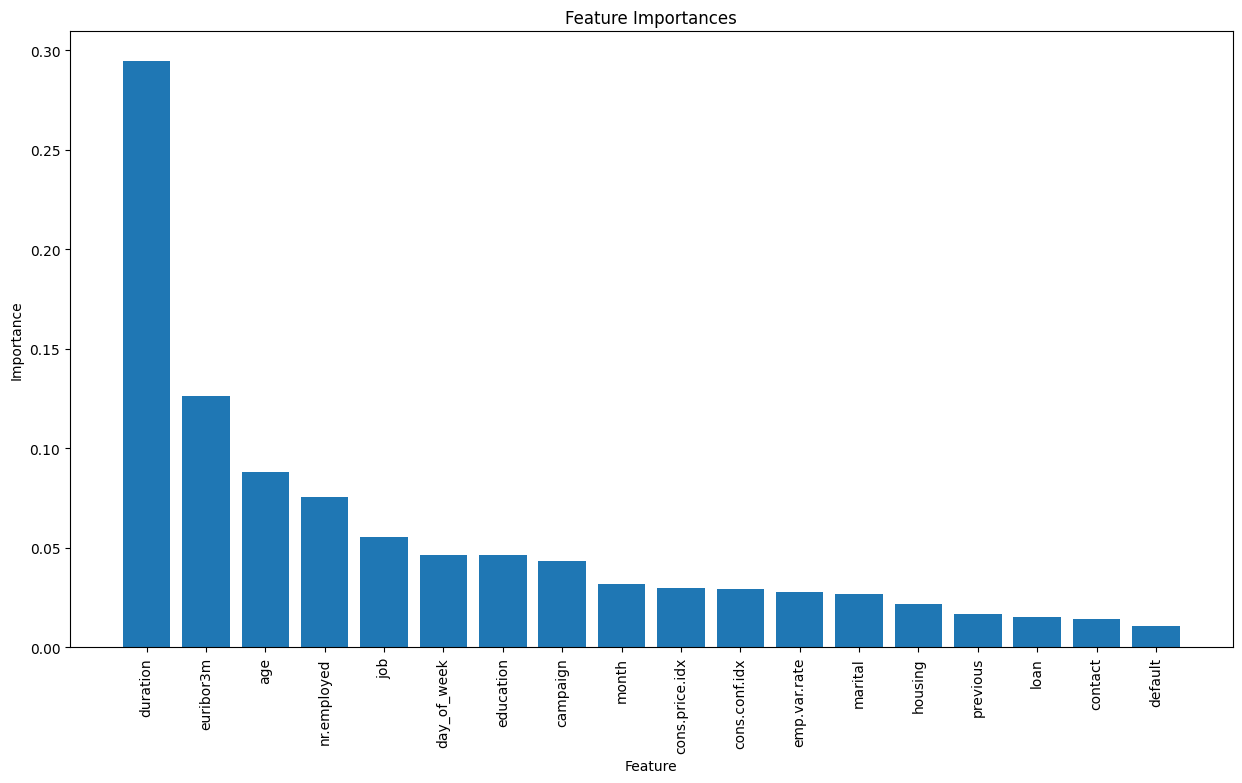

In [17]:
feature_names = X.columns 

# Sort indices and feature names based on importances
indices = feature_importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(15, 8))
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [18]:
df['nr.employed_euribor3m'] = df['nr.employed'] * df['euribor3m']

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

param_grid = {
    'SVM': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200, 300, 400, 500],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 11, 13, 15, 17],
    },
    'LogisticRegression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    },
    'AdaBoosting': {
        'classifier__n_estimators': [50, 100, 200, 300]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [50, 100, 200, 300]
    }
}

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(), 
    'Normalizer': Normalizer()
}

models={
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),  
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoosting': AdaBoostClassifier()
}

grid_results = {}

best_model = None
best_accuracy = 0.0

for scaler_name, scaler in scalers.items():
    for model_name, model in models.items():
        pipeline = Pipeline(steps=[
            ('scaler', scaler),
            ('classifier', model)
        ])

        param_grid_model = param_grid.get(model_name, {})  

        # Create GridSearchCV instance
        grid_search = GridSearchCV(pipeline, param_grid=param_grid_model, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Store the results
        grid_results[(scaler_name, model_name)] = {
            'Best Parameters': grid_search.best_params_,
            'Best Cross-Val Accuracy': grid_search.best_score_,
            'Test Accuracy': grid_search.score(X_test, y_test)
        }
        # Check if current model has the highest test accuracy
        if grid_results[(scaler_name, model_name)]['Test Accuracy'] > best_accuracy:
            best_accuracy = grid_results[(scaler_name, model_name)]['Test Accuracy']
            best_model = (scaler_name, model_name)

for (scaler_name, model_name), metrics in grid_results.items():
    print(f"Scaler: {scaler_name}, Model: {model_name}")
    print(f"Best Parameters: {metrics['Best Parameters']}")
    print(f"Best Cross-Val Accuracy: {metrics['Best Cross-Val Accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print("--------------")

print(f"The Best Model is: {best_model} with Test Accuracy: {best_accuracy:.4f}")

# Use the best model to make predictions
best_scaler_name, best_model_name = best_model
best_model_instance = models[best_model_name]
y_pred = grid_search.predict(X_test)

    # Calculate precision, recall, F1-score, and support for the best model
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print("--------------")


Scaler: StandardScaler, Model: SVM
Best Parameters: {'classifier__C': 10, 'classifier__gamma': 0.01}
Best Cross-Val Accuracy: 0.9086
Test Accuracy: 0.9057
--------------
Scaler: StandardScaler, Model: RandomForest
Best Parameters: {'classifier__max_depth': 50, 'classifier__n_estimators': 50}
Best Cross-Val Accuracy: 0.9154
Test Accuracy: 0.8988
--------------
Scaler: StandardScaler, Model: KNN
Best Parameters: {'classifier__n_neighbors': 15}
Best Cross-Val Accuracy: 0.9007
Test Accuracy: 0.8998
--------------
Scaler: StandardScaler, Model: LogisticRegression
Best Parameters: {'classifier__C': 0.1}
Best Cross-Val Accuracy: 0.9112
Test Accuracy: 0.9067
--------------
Scaler: StandardScaler, Model: DecisionTree
Best Parameters: {}
Best Cross-Val Accuracy: 0.8850
Test Accuracy: 0.8743
--------------
Scaler: StandardScaler, Model: GradientBoosting
Best Parameters: {'classifier__n_estimators': 100}
Best Cross-Val Accuracy: 0.9112
Test Accuracy: 0.8998
--------------
Scaler: StandardScaler, M

After testing several models, I have come to a conclusion that:

One-Hot-Encoding
The Best Model is: ('RobustScaler', 'LogisticRegression') with Test Accuracy: 0.9116
Precision: 0.8998
Recall: 0.9037
F1-score: 0.9016

Label Encoding
The Best Model is: ('StandardScaler', 'AdaBoosting') with Test Accuracy: 0.9077
Precision: 0.8955
Recall: 0.9008
F1-score: 0.8979

In [27]:
import joblib
joblib.dump(best_model_instance, "my_bank_model.pkl")

['my_bank_model.pkl']